# Bollinger's analysis and position limits

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
plt.style.use('seaborn')

C:\Users\91956\AppData\Local\Temp\ipykernel_12140\574551918.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Getting csv data with historical ask, bid values

In [34]:
csv_filepath = 'data/e5bd6481-6804-4177-ab89-77290e04517c.csv'
csv_trade = pd.read_csv(csv_filepath, sep=';')

In [35]:
df_banana = csv_trade[csv_trade['product'] == 'BANANAS'].sort_values(by=["timestamp"])
df_pearl = csv_trade[csv_trade['product'] == 'PEARLS'].sort_values(by=["timestamp"])

In [4]:
df_pearl.tail()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
3991,-1,199500,PEARLS,9996,1,9995.0,21.0,NaN,NaN,9998,2,10004.0,1.0,10005.0,21.0,9997.0,2058.0
3992,-1,199600,PEARLS,9995,28,NaN,NaN,NaN,NaN,10005,28,NaN,NaN,NaN,NaN,10000.0,2058.0
3995,-1,199700,PEARLS,10002,1,9996.0,2.0,9995.0,28.0,10004,2,10005.0,28.0,NaN,NaN,10003.0,2058.0
3997,-1,199800,PEARLS,9996,1,9995.0,27.0,NaN,NaN,10004,1,10005.0,27.0,NaN,NaN,10000.0,2058.0
3999,-1,199900,PEARLS,9998,9,9995.0,25.0,NaN,NaN,10005,25,NaN,NaN,NaN,NaN,10001.5,2058.0


In [5]:
df_banana.tail()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
3990,-1,199500,BANANAS,4930,22,NaN,NaN,NaN,NaN,4937,22,NaN,NaN,NaN,NaN,4933.5,1355.6094
3993,-1,199600,BANANAS,4930,28,NaN,NaN,NaN,NaN,4937,28,NaN,NaN,NaN,NaN,4933.5,1357.2031
3994,-1,199700,BANANAS,4931,30,NaN,NaN,NaN,NaN,4937,2,4938.0,28.0,NaN,NaN,4934.0,1374.5156
3996,-1,199800,BANANAS,4931,1,4930.0,27.0,NaN,NaN,4937,28,NaN,NaN,NaN,NaN,4934.0,1367.4766
3998,-1,199900,BANANAS,4931,9,4930.0,25.0,NaN,NaN,4932,3,4937.0,25.0,NaN,NaN,4931.5,1367.8125


In [36]:
csv_trade.groupby('product').agg({'mid_price': ['mean', 'std', 'min', 'max']})

mid_price                           
              mean       std     min      max
product                                      
BANANAS  4938.2895  7.958996  4924.5   4956.0
PEARLS   9999.9935  1.493427  9996.5  10003.5

## Bollinger's band Analysis 
### First for Bananas

In [37]:
def SMA(data, period, column = 'mid_price'):
    return data[column].rolling(window = period).mean()

# Setting up Bananas DF
df_banana['SMA20'] = SMA(df_banana, 20)
df_banana['SMA50'] = SMA(df_banana, 50)
df_banana['SMA80'] = SMA(df_banana, 80)
df_banana['stdev'] = df_banana.mid_price.rolling(window = 20).std()
df_banana['Upper'] = df_banana.SMA20 + 2*df_banana.stdev
df_banana['Lower'] = df_banana.SMA20 - 2*df_banana.stdev 
 # Buy & Sell signals
# df_banana['Buy_Signal'] = np.where(df_banana.Lower > df_banana.mid_price, True, False)
# df_banana['Sell_Signal'] = np.where(df_banana.Upper < df_banana.mid_price, True, False)

In [79]:
def next_volume(curr_pos : int, position_limit = 20) ->tuple:
    if curr_pos < 0:
        buy_vol = position_limit
    else:
        buy_vol = position_limit - curr_pos
    if curr_pos > 0:
        sell_vol = -1 * position_limit
    else:
        sell_vol = -1 * position_limit - curr_pos
    return buy_vol, sell_vol

In [102]:
profit = 0
buy_signal = []
sell_signal = []
flag = True
curr_vol = 0
position_limit = 20

for i in range(len(df_banana)):
    if df_banana.Lower.iloc[i] > df_banana.mid_price.iloc[i]:
        if flag:
            buy_vol, sell_vol = next_volume(curr_vol)
#             print(f"BUY ==== buy_vol = {buy_vol}, sell_vol = {sell_vol}, curr_vol = {curr_vol}")
            
            profit -= df_banana["ask_price_1"].iloc[i] * min(df_banana["ask_volume_1"].iloc[i], buy_vol)
            curr_vol += min(df_banana["ask_volume_1"].iloc[i], buy_vol)
#             print("Buy curr_vol = ", curr_vol, df_banana["ask_volume_1"].iloc[i])
            flag = False
            buy_signal.append(True)
            sell_signal.append(False)
        else:
            buy_signal.append(False)
            sell_signal.append(False)
            
    elif df_banana.Upper.iloc[i] < df_banana.mid_price.iloc[i]:
        if not flag:

            sell_vol, buy_vol = next_volume(curr_vol)
#             print(f"BUY ==== buy_vol = {buy_vol}, sell_vol = {sell_vol}, curr_vol = {curr_vol}")
    
            profit -= df_banana["bid_price_1"].iloc[i] * min(-1 *df_banana["bid_volume_1"].iloc[i], sell_vol)
            curr_vol -= min(df_banana["bid_volume_1"].iloc[i], sell_vol)
#             print("Sell curr_vol = ", curr_vol, df_banana["bid_volume_1"].iloc[i])
            
            flag = True
            buy_signal.append(False)
            sell_signal.append(True)
        else:
            buy_signal.append(False)
            sell_signal.append(False)
    else:
        buy_signal.append(False)
        sell_signal.append(False)

# Settling remaning volume
print(f"Volume remaning = {curr_vol}, current profit = {profit}")
if curr_vol > 0:
    profit += df_banana["bid_price_1"].iloc[-1] * curr_vol
else:
    profit += df_banana["ask_price_1"].iloc[-1] * curr_vol
curr_vol -= curr_vol

print(f"Total profit earned is {profit} and remaning vol is {curr_vol}")
            
# print(profit, curr_vol)

Volume remaning = 20, current profit = 281181
Total profit earned is 379801 and remaning vol is 0


In [94]:
sum(buy_signal), sum(sell_signal)

(35, 35)

In [96]:
df_banana["Buy_Signal"] = buy_signal
df_banana["Sell_Signal"] = sell_signal

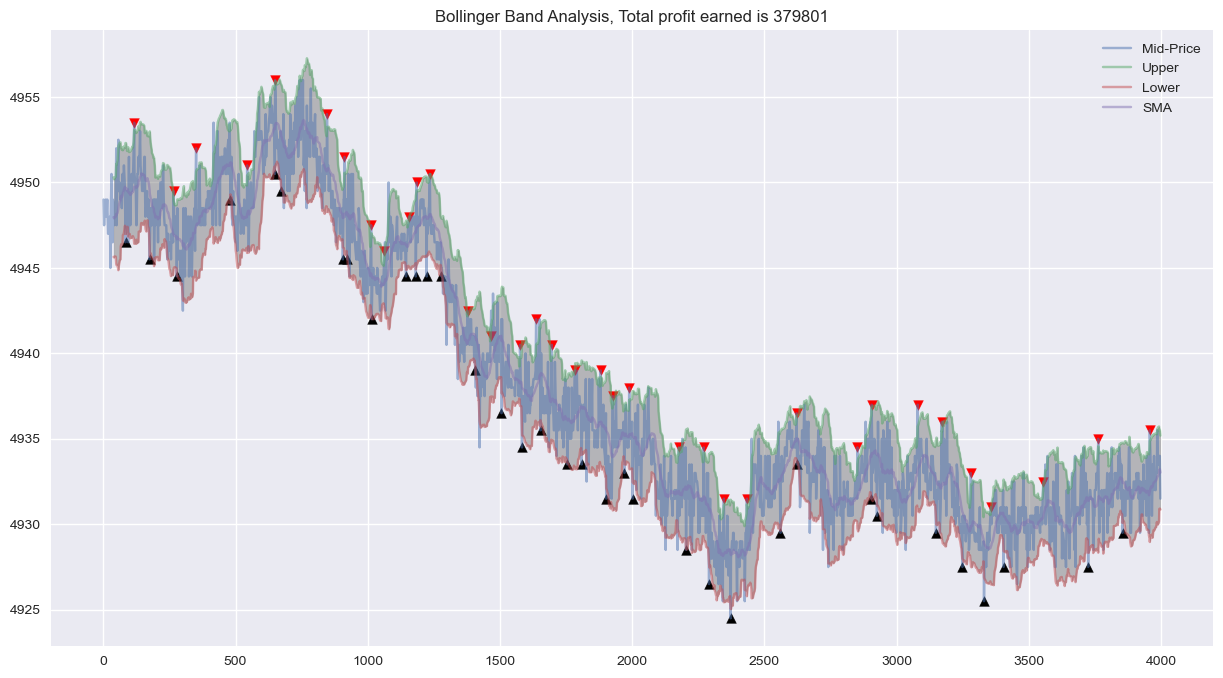

In [104]:
plt.figure(figsize = (15,8))
plt.plot(df_banana[['mid_price', 'Upper', 'Lower', 'SMA20']], alpha=0.5)
plt.fill_between(df_banana.index, df_banana.Upper, df_banana.Lower, color = 'grey', alpha = 0.5)
plt.scatter(df_banana.index[df_banana.Buy_Signal], df_banana[df_banana.Buy_Signal].mid_price, marker = '^', color = 'black')
plt.scatter(df_banana.index[df_banana.Sell_Signal], df_banana[df_banana.Sell_Signal].mid_price, marker = 'v', color = 'red')
plt.title(f"Bollinger Band Analysis, Total profit earned is {profit}")
plt.legend(['Mid-Price', 'Upper', 'Lower', 'SMA'])

In [39]:
# profit = 0
# buy_signal = []
# sell_signal = []
# flag = True
# curr_vol = 0

# for i in range(len(df_banana)):
#     if df_banana.Lower.iloc[i] > df_banana.mid_price.iloc[i]:
#         if flag:
#             profit -= df_banana["ask_price_1"].iloc[i] * df_banana["ask_volume_1"].iloc[i]
#             curr_vol += df_banana["ask_volume_1"].iloc[i]
#             flag = False
#             buy_signal.append(True)
#             sell_signal.append(False)
#         else:
#             buy_signal.append(False)
#             sell_signal.append(False)
            
#     elif df_banana.Upper.iloc[i] < df_banana.mid_price.iloc[i]:
#         if not flag:
#             profit -= df_banana["bid_price_1"].iloc[i] * min(df_banana["bid_volume_1"].iloc[i], curr_vol)
#             curr_vol -= min(df_banana["bid_volume_1"].iloc[i], curr_vol)
#             buy_signal.append(False)
#             sell_signal.append(True)
#             flag = True
#         else:
#             buy_signal.append(False)
#             sell_signal.append(False)
#     else:
#         buy_signal.append(False)
#         sell_signal.append(False)

# # Setting remaning volume
# if curr_vol > 0:
#     profit += df_banana["bid_price_1"].iloc[-1] * curr_vol
# else:
#     profit += df_banana["ask_price_1"].iloc[-1] * curr_vol

# print(f"Total profit earned is {profit} and remaning vol is {curr_vol}")

Total profit earned is -859702 and remaning vol is 64
